# Tutorial 4

In this tutorial we consider a generalised form of the elastic sea level problem and an associated reciprocity theorem. Doing so is necessary to obtain sensitivity kernels for other observables that do not depend only on the sea level change. 

Within the generalised sea level problem there are four force-terms:
- The direct load, $\zeta$. 
- A displacement load, $\zeta_{\mathbf{u}}$, This corresponds to applying the traction of a surface load without accounting for the associated surface mass.
- A gravitational potential load, $\zeta_{\phi}$. This corresponds to a surface mass without accounting for the associated traction. 
- A change in the system's angular momentum, $\Delta \mathbf{l}$, currently implemented only for the components orthogonal to the equilibrium rotation axis. 

Neither the displacement nor gravitational potential loads contribute to the mass balance between the oceans and ice sheets. Thus, changes to the mean sea level can *only* be generated by a non-zero direct load. 


The reciprocity theorem for the generalised sea level equation states that
$$
\int_{\partial M} \zeta^{\dagger} \Delta SL \, \mathrm{d} S - \frac{1}{g}\int_{\partial M}[\zeta_{\mathbf{u}}^{\dagger}\nabla\Phi \cdot \mathbf{u} + \zeta_{\phi}^{\dagger}(\phi+\psi)] \, \mathrm{d} S 
-\frac{1}{g} \Delta \mathbf{l}^{\dagger}\cdot {\omega}
\\= \int_{\partial M} \zeta \Delta SL^{\dagger} \, \mathrm{d} S - \frac{1}{g}\int_{\partial M}[\zeta_{\mathbf{u}}\nabla\Phi \cdot \mathbf{u}^{\dagger} + \zeta_{\phi}(\phi^{\dagger}
+\psi^{\dagger})] \, \mathrm{d} S 
-\frac{1}{g} \Delta \mathbf{l}\cdot {\omega}^{\dagger}
$$
for any two pairs of forces and responses. 


### Checking the reciprocity theorem

First we generate random force terms to test the generalised reciprocity theorem.


In [8]:
# Import necessary modules.
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from pyslfp import FingerPrint


# Set up the fingerprint instance.
fingerprint = FingerPrint(lmax=256)
fingerprint.set_state_from_ice_ng()


def random_disk_load():
    """
    Function that returns a randomised load for testing.
    """
    delta = np.random.uniform(10, 30)
    lat = np.random.uniform(-90, 90)
    lon = np.random.uniform(-180, 180)
    amp = np.random.randn()
    return fingerprint.disk_load(delta, lat, lon, amp)


def random_angular_momentum():
    """
    Function that returns a randomised angular momentum jump
    whose magnitude is comparable that of the loads.
    """
    b = fingerprint.mean_sea_floor_radius
    omega = fingerprint.rotation_frequency
    load = random_disk_load()
    load_lm = load.expand(lmax_calc=2)
    return omega * b**4 * load_lm.coeffs[:, 2, 1]


direct_load_1 = random_disk_load()
direct_load_2 = random_disk_load()
displacement_load_1 = random_disk_load()
displacement_load_2 = random_disk_load()
gravitational_potential_load_1 = random_disk_load()
gravitational_potential_load_2 = random_disk_load()
angular_momentum_change_1 = random_angular_momentum()
angular_momentum_change_2 = random_angular_momentum()

(
    sea_level_change_1,
    displacement_1,
    gravity_potential_change_1,
    angular_velocity_change_1,
) = fingerprint(
    direct_load=direct_load_1,
    displacement_load=displacement_load_1,
    gravitational_potential_load=gravitational_potential_load_1,
    angular_momentum_change=angular_momentum_change_1,
)

(
    sea_level_change_2,
    displacement_2,
    gravity_potential_change_2,
    angular_velocity_change_2,
) = fingerprint(
    direct_load=direct_load_2,
    displacement_load=displacement_load_2,
    gravitational_potential_load=gravitational_potential_load_2,
    angular_momentum_change=angular_momentum_change_2,
)

g = fingerprint.gravitational_acceleration

lhs_integrand = direct_load_2 * sea_level_change_1 - (1 / g) * (
    g * displacement_load_2 * displacement_1
    + gravitational_potential_load_2 * gravity_potential_change_1
)
lhs = (
    fingerprint.integrate(lhs_integrand)
    - np.dot(angular_momentum_change_2, angular_velocity_change_1) / g
)

rhs_integrand = direct_load_1 * sea_level_change_2 - (1 / g) * (
    g * displacement_load_1 * displacement_2
    + gravitational_potential_load_1 * gravity_potential_change_2
)
rhs = (
    fingerprint.integrate(rhs_integrand)
    - np.dot(angular_momentum_change_1, angular_velocity_change_2) / g
)


print(f"lhs of identity =  {lhs}")
print(f"rhs of identity =  {rhs}")
print(f"relative difference = {np.abs(rhs-lhs)/np.abs(rhs)}\n")


lhs of identity =  -675468280.4198858
rhs of identity =  -675537709.1722705
relative difference = 0.00010277553931053261



### Sensitivity kernels for displacement observations

Consider the standard fingerprint calculation in which only a direct load, $\zeta$, is included. If, within the reciprocity theorem, we take $\zeta^{\dagger}_{\mathbf{u}} = -\delta_{\mathbf{x}_{0}}$ and set all other daggered force terms to zero we find
$$
u(\mathbf{x}_{0}) = \int_{\partial M} \Delta SL^{\dagger} \zeta \, \mathrm{d}S, 
$$
where we write $u$ for the vertical displacement. 

This allows us to calculate the sensitivity kernel for a point measurement of the vertical displacement. The corresponding kernel with respect to ice thickness change is, as before, given by:
$$
K = \rho_{i}(1-C)\Delta SL^{\dagger}
$$

These ideas are implemented below:

Displacement at observation point =  16.34253773m
Predicted displacement using sensitivity kernel = 16.34252296m
Relative difference = 9.041232718923806e-07



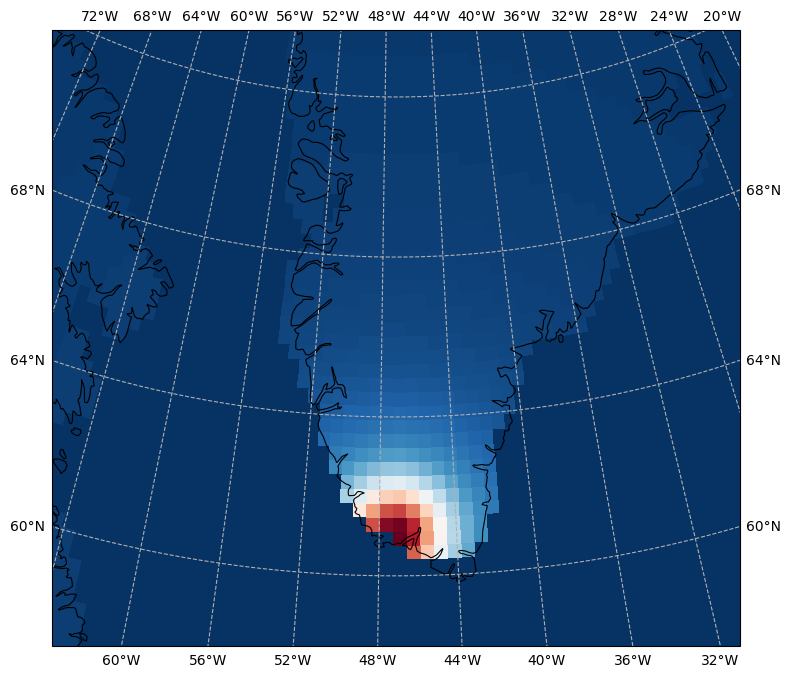

In [13]:
# Set the observation point for SENU GPS station in Greenland
lat = 61.0696
lon = -47.1413


# Set the direct load
direct_load = fingerprint.northern_hemisphere_load()

# Solve the forward problem
_, displacement, _, _ = fingerprint(direct_load=direct_load, rtol=1e-9)


# Get the displacement at the observation point.
displacement_observed = fingerprint.point_evaulation(displacement, lat, lon)

# Set the adjoint displacement load. In this case we use a method that
# does the calculation for us. Other adjoing force terms are returned as
#  None and here ignored.
adjoint_displacement_load = -1 * fingerprint.point_load(lat, lon)

# Solve the adjoint problem.
adjoint_sea_level_change, _, _, _ = fingerprint(
    displacement_load=adjoint_displacement_load, 
    rtol=1e-9
)


# Print the observed value and prediction via sensitivity kernel
print(f"Displacement at observation point =  {displacement_observed:.8f}m")
displacement_prediction = fingerprint.integrate(adjoint_sea_level_change * direct_load)
print(
    f"Predicted displacement using sensitivity kernel = {displacement_prediction:.8f}m"
)
print(
    f"Relative difference = {np.abs(displacement_observed-displacement_prediction)/np.abs(displacement_observed)}\n"
)

# Recalculate a smoothed kernel for plotting. In this case we use a method that does the
# calculation for us. Other adjoint force terms are returned and None and here ignored.
_, adjoint_displacement_load, _, _ = (
    fingerprint.adjoint_loads_for_displacement_point_measurement(
        lat, lon, smoothing_angle=1.0
    )
)
adjoint_sea_level_change, _, _, _ = fingerprint(
    displacement_load=adjoint_displacement_load, 
    rtol=1e-9
)
kernel = fingerprint.direct_load_from_ice_thickness_change(adjoint_sea_level_change)

fig, ax, im = fingerprint.plot(
    kernel,
    projection=ccrs.Orthographic(central_longitude=lon, central_latitude=lat + 8),
    map_extent=[lon - 16, lon + 16, lat - 4, lat + 12],
    lat_interval=4,
    lon_interval=4,
)
plt.show()


### Sensitivity kernels for gravitational potential measurements

We now consider the calculation of sensitivity kernels for a measurement of a particular spheical harmonic coefficient of the gravitational potential. The form of the adjoint forces in this cases is slightly more involved because we need to separate out the gravitational and centrifugal contributions. The non-zero adjoint forces are:
$$
\zeta_{\phi}^{\dagger} = -\frac{g}{b^{2}} Y_{lm}, \quad \Delta \mathbf{l}^{\dagger}= \int_{\partial M} \zeta_{\phi}^{\dagger} \mathbf{x}\times(\Omega \times \mathbf{x}) \,\mathrm{d} S, 
$$
with $b$ the radius of the Earth model. Note that these expressions are found in eq.(66) of Al-Attar *et al.* (2014) but the first term here contains factor of  $b^{-2}$ that was accidently missed in the paper.

The code below implements these ideas. In particular, we see that a method of the ```FingerPrint``` class is used to generate the necessary adjoint load. Within this method, 
the determination of $\Delta \mathbf{l}^{\dagger}$ from $\zeta^{\dagger}_{\phi}$ is done using the method ```angular_momentum_change_from_gravitational_potential_load```.

The degree 2 and order -1 coefficient = -68.032386203821
Integral of direct load against adjoint sea level -68.03250505775242
Relative difference = 1.7470198833735299e-06


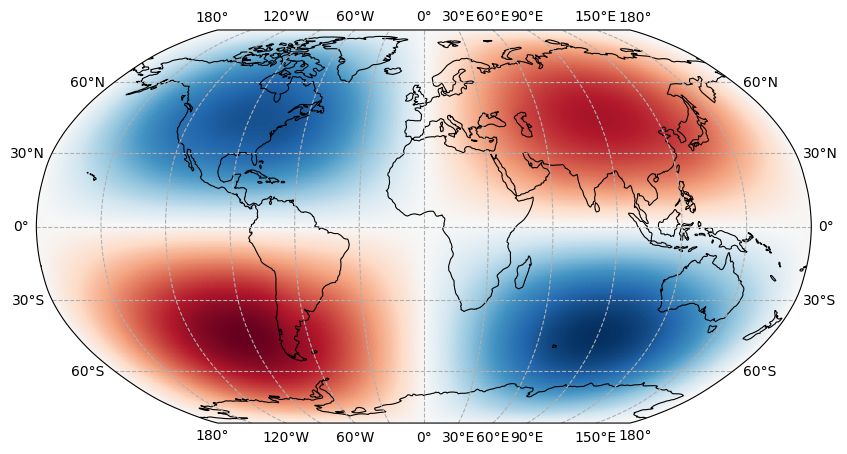

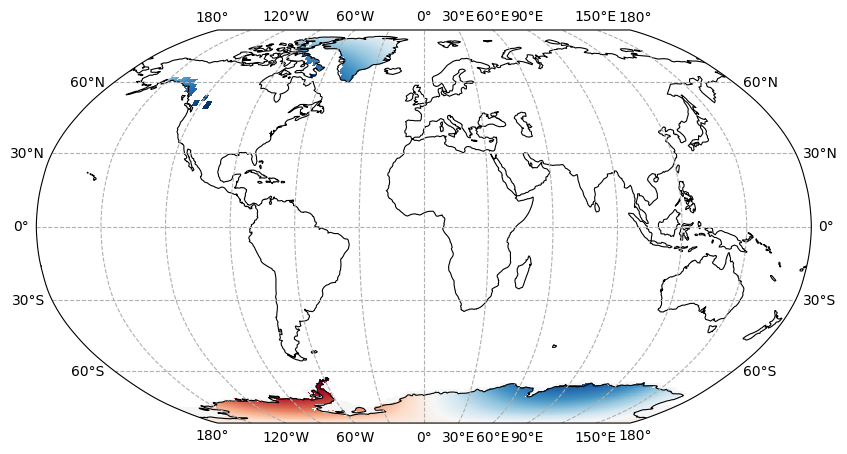

In [14]:
# Set the direct load
direct_load = fingerprint.southern_hemisphere_load()

# Solve the forward problem
_, _, gravity_potential_change, angular_velocity_change = fingerprint(
    direct_load=direct_load, rtol=1e-9
)

# Get the gravitational potential change.
gravitational_potential_change = (
    fingerprint.gravity_potential_change_to_gravitational_potential_change(
        gravity_potential_change, angular_velocity_change
    )
)

# set the observation degree and order
l = 2
m = -1


# Print the coefficient.
observed_coefficient = fingerprint.coefficient_evaluation(
    gravitational_potential_change, l, m
)
print(f"The degree {l} and order {m} coefficient = {observed_coefficient}")


# Get the adjoint load.
_, _, adjoint_gravitational_potential_load, adjoint_angular_momentum_change = (
    fingerprint.adjoint_loads_for_gravitational_potential_coefficient(l, m)
)

# Solve the adjoint problem.
adjoint_sea_level_change, _, _, _ = fingerprint(
    gravitational_potential_load=adjoint_gravitational_potential_load,
    angular_momentum_change=adjoint_angular_momentum_change,
)

predicted_coefficient = fingerprint.integrate(adjoint_sea_level_change * direct_load)
print(f"Integral of direct load against adjoint sea level {predicted_coefficient}")

print(
    f"Relative difference = {np.abs(observed_coefficient-predicted_coefficient)/ np.abs(observed_coefficient)}"
)

# Plot the adjoint sea level.
fingerprint.plot(adjoint_sea_level_change)

# Plot the corresponding ice thickness kernel
kernel = fingerprint.direct_load_from_ice_thickness_change(adjoint_sea_level_change)
fingerprint.plot(kernel, ice_projection=True)

plt.show()
